<center><a target="_blank" href="https://academy.constructor.org/"><img src=https://lh3.googleusercontent.com/d/1EmH3Jks5CpJy0zK3JbkvJZkeqWtVcxhB width="500" style="background:none; border:none; box-shadow:none;" /></a> </center>
<hr />

# <h1 align="center"> DST Day 4, Exercise 1 Part 1: Webscraping jobs.ch with BeautifulSoup </h1>

<hr />
<center>Constructor Academy, 2024</center>


<div style="background:#EEEDF5;border-top:0.1cm solid #EF475B;border-bottom:0.1cm solid #EF475B;">
    <div style="margin-left: 0.5cm;margin-top: 0.5cm;margin-bottom: 0.5cm;color:#303030">
        <p><strong>Goal:</strong> Scrape job details from jobs.ch and store data as a csv file</p>
        <strong> Outline:</strong>
        <a id='Q0' name="Q0"></a>
        <ol>
            <li> <a style="color:#303030" href='#Q1'>Setup</a></li>
            <li> <a style="color:#303030" href='#Q2'>Getting webpage content using the requests library</a></li>
            <li> <a style="color:#303030" href='#Q3'>Building and saving the dataframe</a></li>
            <li> <a style="color:#303030" href='#Q4'>Conclusion</a></li>
        </ol>
        <strong>Topics Trained:</strong> Web Scraping, HTML, requests, BeautifulSoup 
    </div>
</div>

<nav style="text-align:right"><strong>
        <a style="color:#00BAE5" href="https://monolith.propulsion-home.ch/backend/api/momentum/materials/ds-materials/01_DSToolkit/index.html" title="momentum"> Module 1, The Data Science Toolkit </a>|
        <a style="color:#00BAE5" href="https://monolith.propulsion-home.ch/backend/api/momentum/materials/ds-materials/01_DSToolkit/day4/index.html" title="momentum">Day 4, Web Scraping </a>|
        <a style="color:#00BAE5" href="https://monolith.propulsion-home.ch/backend/api/momentum/materials/ds-materials/01_DSToolkit/day4/pages/exercises.html#id1" title="momentum"> Exercise 1: Scrape Jobs.ch</a>
</strong></nav>

As a job seeker, one has to search through job portals to find the most relevant jobs related to your profile. In this exercise, your goal is to find all jobs related to keywords: “Data Scientist”, “Data Analyst”, “Python Developer”, “Data Engineer”, “Data Manager”, “Data Architect”, “Big Data Analyst” and “Data Python” on jobs.ch.

To do this, we are going to scrape as much information as possible regarding these position.

<div style="background:#EEEDF5;border:0.1cm solid #00BAE5;color:#303030">
    <div style="margin: 0.2cm 0.2cm 0.2cm 0.2cm">
       <b style="color:#00BAE5">The Steps of Webscraping:</b>
      <ol> 
          <li> Check the robots.txt file to make sure you are allowed to scrape the page</li>
          <li> Get content of the webpage/url using the requests library </li>
          <li> Parse content using BeautifulSoup </li>
          <li> Define the information/data that you require </li>
          <li> Use find() to navigate through parsed html </li>
          <li> Use get() to extract required information </li>
          <li> Save extracted data into a pandas dataframe and/or csv file. </li>
      </ol>
   </div>
</div>

In [9]:
from bs4 import BeautifulSoup  # to parse html
import requests # to send http requests

# function that allows you to pause the program. helpful to stagger requests
from time import sleep
from tqdm import tqdm

import pandas as pd
import re

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

<a id='Q2' name="Q2"></a>
## [Getting webpage content using the requests library](#Q0)

### Robots.txt

The first thing we need to do is to head over https://www.jobs.ch/robots.txt to read the guidelines about scraping this website:

```
# www.jobs.ch

User-agent: *
Disallow: /external/
Disallow: /api/
Disallow: /api/v1/
Disallow: /api_proxy/
Disallow: /de/_uploader
Disallow: /en/_uploader
Disallow: /fr/_uploader
Disallow: /de/registrieren/
Disallow: /fr/inscription/
Disallow: /en/register/
Disallow: /de/login/*?
Disallow: /fr/login/*?
Disallow: /en/login/*?
Disallow: /login/
Disallow: /Login/
Disallow: /de/auth/
Disallow: /fr/auth/
Disallow: /en/auth/
Disallow: /0
Disallow: /1
Disallow: /2
Disallow: /3
Disallow: /4
Disallow: /5
Disallow: /6
Disallow: /7
Disallow: /8
Disallow: /9
Disallow: /de/stellenangebote/detail/*/*/*
Disallow: /en/vacancies/detail/*/*/*
Disallow: /fr/offres-emplois/detail/*/*/*
Disallow: *-two-column/*

User-agent: SemrushBot
Disallow: /

Sitemap: https://www.jobs.ch/sitemaps/sitemap.xml
```

You can see the list of urls that are off limits for `jobs.ch`. In this documentation, the developers used the `*` notation, also called a wild card. When this is used, that means "any".

For example:

- the line `User-agent: *` means the following rule apply to any agent (= webscraping script).
- `Disallow: /en/vacancies/detail/*/*/*` means do not scrape url of the form https://www.jobs.ch/en/vacancies/detail/ any string / any string / any string

### URL pattern

After inspection of an [example search page](https://www.jobs.ch/en/vacancies/?page=2&region=19&term=data%20engineer), we find that it follows the pattern:

  https://www.jobs.ch/en/vacancies/?page={page}&region={reg}&term={key%20word}
  
  with 
  - {page} the page number of the research,
  - {reg} the region code
  - {key%20word} the search keyword, with each space replaced by %20
  
for example, checkout https://www.jobs.ch/en/vacancies/?page=2&region=19&term=data%20engineer

If we are interested in reading a specific job ad, we can see that the url pattern can be modified to:

https://www.jobs.ch/en/vacancies/?page={page}&region={reg}&term={key%20word}&jobid={jobid}

to access specific job details. So our first task will be to parse the search pages to get the list urls of all the individual job descriptions, and then parse each job description for more content.

In [10]:
keywords = [
    "Data Scientist",
    "Data Analyst",
    "Python Developer",
    "Data Engineer",
    "Data Manager",
    "Data Architect",
    "Big Data Analyst",
    "Data Python",
]

### Scrape Search page for urls of individual jobs descriptions

We already explored the search page during livecoding. here is what we found:

- for each page, we can find hyper links to individual job ads by parsing all `a` elements with attribute `data-cy` of value `job-link`:

```python
job_ads = soup.find_all("a", {"data-cy": "job-link"})
```

from this, we can get the link to the details page by iterating over `job_ads` and getting the `href` field:

```python
job_links = []
job_ads = soup.find_all("a", {"data-cy": "job-link"})
for job_ad in job_ads:
    job_links.append(url + '&jobid=' + job_ad.get("href").split('/')[-2])
```

the problem is, this link is of the form:

https://www.jobs.ch/en/vacancies/detail/{job_id}/?source=vacancy_search_promo

which corresponds to the pattern on the robots.txt file: `Disallow: /en/vacancies/detail/*/*/*`.

Fortunately, we can extract the jobid variable like so:

```python
job_ad.get("href").split('/')[-2]
```

and reconstruct the url we found in the section above, which is allowed:

https://www.jobs.ch/en/vacancies/?page={page}&region={reg}&term={key%20word}&jobid={jobid}

Finally, we can directly send a get request to the url and save the response onto a file. To do that we use the following syntax:

```python
with open(full_file_name, "wb") as f:
    f.write(page_content)
```

we can then reload the page later on by typing:

```python
with open(full_file_name, 'rb') as f:
    page_content = f.open()
```

Here is the function that downloads all the job pages for us:

Besides all the individual job descriptions for a given search page, we also need to go over all the pages for a given search. For this, we need to extract the total number of pages per search, and then construct the url pattern as follows:

https://www.jobs.ch/en/vacancies/?page={page}&region={reg}&term={key%20word}

we find that the maximum number of pages is given in the `span` element with attribute `data-cy` of value `page-count`.
Once we have the number of pages, we can loop over them to extract all the job pages and ids (within `a` elements of `data-cy = job-link`).

---
1.1. Download all necessary information (including job text, job rank, company name, job keyword…) for all webpages.

**Note**

We are always using the structure 

```python
try:
    # extract some information
except:
    # the information extraction failed, fill result with nan
```

this prevents the code from stopping whenever an information is not available for a given job ad

As you can see from the function above, extracting the content of the ad is a bit tricky. For some job ads, Jobs.ch is actually embeding the description within its page in an iframe element and for other, it is in a div element. we write a nested `try ... except ...` block to make sure we get all the data. 

In [14]:
import time

contract_types = ['Apprenticeship', 'Freelance', 'Internship',
                  'Supplementary income', 'Temporary', 'Unlimited employment']
# validate contract types via: https://www.jobs.ch/en/advanced-search-vacancies/

def get_all_pages(keyword, df):
    processed_profesion = keyword.lower().replace(" ", "%20")
    try:
        page = requests.get(f"https://www.jobs.ch/en/vacancies/?term={processed_profesion}", timeout=15)
    except requests.RequestException as e:
        print(f"Failed to load initial page: {e}")
        return []
    soup = BeautifulSoup(page.content, "html.parser")

    # Extracting max pages
    max_pages = soup.find('div', {'data-cy':'paginator'}).find_all('span')[-4].text.split()[-1]
    print(f"{max_pages} pages found for {keyword}...")
    
    for pg in tqdm(range(1, int(max_pages) + 1)):
        url = f"https://www.jobs.ch/en/vacancies/?page={pg}&term={keyword}"
        try:
            page = requests.get(url, timeout=15)
            soup = BeautifulSoup(page.content, "html.parser")
        except requests.RequestException as e:
            print(f"Failed to load page {pg}: {e}")
            continue
        base_link = "https://www.jobs.ch"
        time.sleep(1)
        job_ads = soup.find_all('article', {'data-cy' : 'serp-item'})
        for job_ad in job_ads:
            job_link = job_ad.find('a', {'data-cy': 'job-link'}).get('href')
            job_url = base_link + job_link
            title = job_ad.find('a', {'data-cy': 'job-link'}).get('title')
            
            try:
                publish = job_ad.find_all('p')[0].text
            except IndexError:
                publish = None
                
            try:
                location = job_ad.find_all('p')[1].text
            except IndexError:
                location = None
                
            try:
                workload = job_ad.find_all('p')[2].text
            except IndexError:
                workload = None
                
            try:
                empoy_type = job_ad.find_all('p')[3].text
            except IndexError:
                empoy_type = None
            try:
                company = job_ad.find_all('p')[4].text
            except IndexError:
                company = None
        
        # 'url', 'title', 'publish_date','location','workload','employment_type','company'
            job_dict = {
                        "profession" : keyword,
                        "url": job_url,
                        "title": title,
                        "publish_date": publish,
                        "location": location,
                        "workload": workload,
                        "employment_type": empoy_type,
                        "company": company
                    }
        
            df = pd.concat(
                [df, pd.DataFrame([job_dict])],
                ignore_index=True,
            )
    print(len(df), "job postings retrieved.\n")
    return df

In [15]:
#all_jobs = {k:get_all_pages(k) for k in keywords}
df = pd.DataFrame(columns=['profession', 'url', 'title', 'publish_date','location','workload','employment_type','company'])
for job_desc in keywords:
    df = get_all_pages(job_desc, df)

12 pages found for Data Scientist...


100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


235 job postings retrieved.

14 pages found for Data Analyst...


100%|██████████| 14/14 [00:15<00:00,  1.14s/it]


515 job postings retrieved.

5 pages found for Python Developer...


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


599 job postings retrieved.

74 pages found for Data Engineer...


100%|██████████| 74/74 [01:49<00:00,  1.48s/it]


2075 job postings retrieved.

74 pages found for Data Manager...


100%|██████████| 74/74 [01:48<00:00,  1.46s/it]


3541 job postings retrieved.

9 pages found for Data Architect...


100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


3716 job postings retrieved.

5 pages found for Big Data Analyst...


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


3816 job postings retrieved.

24 pages found for Data Python...


100%|██████████| 24/24 [00:27<00:00,  1.15s/it]

4288 job postings retrieved.



In [16]:
df.head()

,profession,url,title,publish_date,location,workload,employment_type,company
0,Data Scientist,https://www.jobs.ch/en/vacancies/detail/5106c5...,(Senior) Data Platform Engineer,2 weeks ago,"Pfingstweidstrasse 60b, Zürich",80 – 100%,Unlimited employment,Digitec Galaxus AG
1,Data Scientist,https://www.jobs.ch/en/vacancies/detail/25d826...,Fachexperte:in Planung und Steuerung (Datenman...,Last week,Region Bern Mittelland (BE/SO/AG),60 – 100%,Unlimited employment,SBB CFF FFS
2,Data Scientist,https://www.jobs.ch/en/vacancies/detail/d5063a...,Pricing & Data Analyst (m/w/d) Marketing & Sal...,Yesterday,Reinach BL,50%,Unlimited employment,Montagetechnik BERNER AG
3,Data Scientist,https://www.jobs.ch/en/vacancies/detail/638350...,(Senior) Data Science & Data Analytics Consult...,Last month,Zürich,60 – 100%,Unlimited employment,Eraneos Switzerland AG
4,Data Scientist,https://www.jobs.ch/en/vacancies/detail/426c95...,Datenspezialist*in und Applikationsmanager*in,Last week,Zürich,80 – 100%,Unlimited employment,Stadt Zürich – Amt für Hochbauten


---
1.2. Using the information obtained, perform a descriptive analysis on this data including questions:


---
- Are there some companies doing more hires than average?

In [6]:
df.sort_values('company').iloc[0]['url']

'/en/vacancies/detail/ee7617a1-bde1-47b4-9a2f-8dd864eb0258/?source=vacancy_search'

In [17]:
companies_hiring = pd.DataFrame(columns=["company", "job_postings"])

companies_hiring = pd.concat(
    [companies_hiring, df[df['company']!=''].groupby("company").agg(job_postings=("url", "count")).reset_index()]
)

companies_hiring = companies_hiring.sort_values(by="job_postings", ascending=False)
companies_hiring = companies_hiring.drop_duplicates(subset=["company"]).reset_index(drop=True)

print(len(companies_hiring))
companies_hiring.head(10)

1161


,company,job_postings
0,Akros AG,43
1,MSC Cruises SA,43
2,Deloitte AG,40
3,Accenture,35
4,ETH Zürich,30
5,Eraneos Switzerland AG,30
6,ti&m AG,28
7,Ernst & Young AG,27
8,Kurath Engineering AG,25
9,Digitec Galaxus AG,23


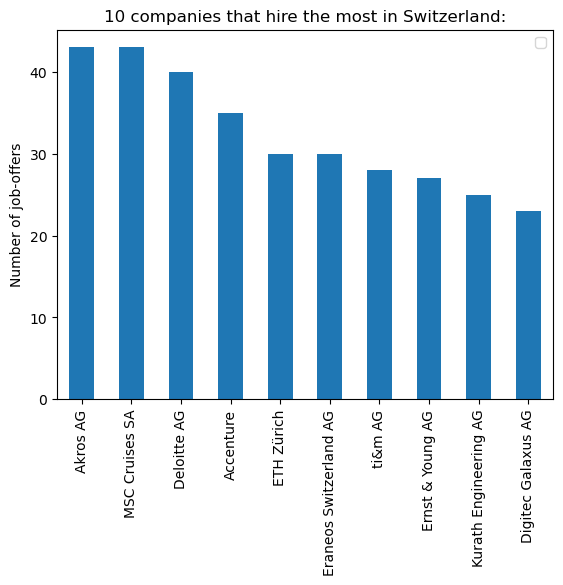

In [18]:
import matplotlib.pyplot as plt

companies_hiring.head(10).plot(x="company", y="job_postings", kind="bar")
plt.title("10 companies that hire the most in Switzerland:")
plt.xlabel("")
plt.ylabel("Number of job-offers")
plt.legend([])
plt.show()

---
- How many jobs are there in different Kantons?

In [9]:
df.to_csv('swiss_job_postings.csv', index = None)

In [ ]:
!pip install pgeocode

In [20]:
import pgeocode
pgeocode_nomi = pgeocode.Nominatim('ch')
switzerland = pgeocode_nomi._data_frame
cantons = switzerland.state_name.unique()

In [12]:
cantons

array(['Canton de Vaud', 'Genève', 'Canton de Fribourg',
       'Canton de Berne', 'Canton du Valais', 'Neuchâtel', 'Jura',
       'Kanton Solothurn', 'Kanton Basel-Landschaft',
       'Kanton Basel-Stadt', 'Kanton Aargau', 'Kanton Luzern',
       'Kanton Nidwalden', 'Kanton Obwalden', 'Kanton Zug', 'Kanton Uri',
       'Kanton Schwyz', 'Ticino', 'Kanton Graubünden',
       'Kanton St. Gallen', 'Kanton Zürich', 'Kanton Schaffhausen',
       'Kanton Thurgau', 'Kanton Glarus', 'Kanton Appenzell Ausserrhoden',
       'Kanton Appenzell Innerrhoden'], dtype=object)

In [21]:
def get_canton_name(x):
    # Normalize input
    x_clean = re.sub(r"[^\w\s]", "", x).strip()
    x_lower = x_clean.lower()

    # Check directly against known canton names
    for canton in cantons:
        if x_lower in canton.lower():
            return canton

    # Attempt to resolve location through postal code or city name
    try:
        query = re.sub(r'\D', '', x_clean)
        if len(query) == 4:  # Swiss postal codes are 4 digits
            postal_result = pgeocode_nomi.query_postal_code(query)
            if postal_result is not None and not postal_result.empty:
                return postal_result["state_name"].values[0]
        # Resolve based on city name
        city_result = pgeocode_nomi.query_location(x_clean)
        if city_result is not None and not city_result.empty:
            return city_result["state_name"].values[0]
    except:
        return None  # Return None if all lookups fail

In [22]:
# Apply function and aggregate data
df['canton'] = df['location'].apply(get_canton_name)
df_cantons = df.groupby("canton").agg(job_postings=pd.NamedAgg(column="url", aggfunc="count")).reset_index()
df_cantons = df_cantons.sort_values(by="job_postings", ascending=False).reset_index(drop=True)

# Display the top 10 cantons with most job postings
print(df_cantons.head(10))

                    canton  job_postings
0            Kanton Zürich           992
1          Canton de Berne           382
2  Kanton Basel-Landschaft           278
3            Kanton Aargau           246
4           Canton de Vaud           218
5            Kanton Luzern           130
6        Kanton St. Gallen           114
7               Kanton Zug            70
8                   Ticino            66
9         Kanton Solothurn            65


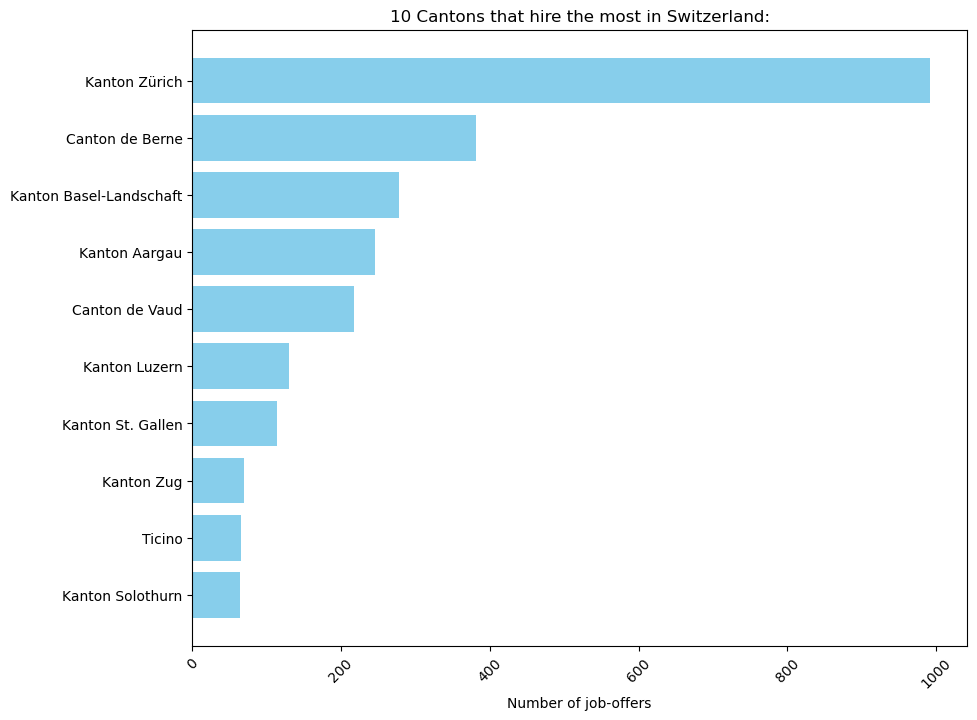

In [23]:
top_cantons = df_cantons.head(10)

plt.figure(figsize=(10, 8))
plt.barh(top_cantons['canton'], top_cantons['job_postings'], color='skyblue')
plt.title("10 Cantons that hire the most in Switzerland:")
plt.xlabel("Number of job-offers")
plt.ylabel("")  
plt.xticks(rotation=45)  
plt.gca().invert_yaxis()
plt.show()